In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from keras.layers import Embedding,GRU,TimeDistributed,RepeatVector,Merge,BatchNormalization
from keras.preprocessing import sequence

import numpy as np
from vgg16 import Vgg16

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL.Image

import json
from tqdm import tqdm

from keras.optimizers import SGD, RMSprop, Adam

from utils import *
import cPickle as pickle
from matplotlib import pyplot as plt

from itertools import compress

import shutil
import string

import collections
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import re
from numpy.random import random, permutation, randn, normal 

import os

import preprocessing as preproc


Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:

def constructImageEntryArr(imageDataArr):
    image_entry_arr = []

    for imageData in imageDataArr:
        image = imageData.image

        for caption in imageData.captions:
            image_entry_arr.append(ImageEntry(image,caption))

    return image_entry_arr


def get_unique_words(captions):
    unique_words = []
    words = [caption.split() for caption in captions]
   
    for word in words:
        unique_words.extend(word)
        
    unique_words = list(set(unique_words))
    
    return unique_words

def get_index_word_dicts(unique_words):
    word_index = {}
    index_word = {}
    for i,word in enumerate(unique_words):
        word_index[word] = i
        index_word[i] = word
        
    return (word_index,index_word)

def get_train_captions_indexed(captions, word2index, MAX_CAPTION_LEN ):
    
    train_captions_indexed = []
    for caption in captions:
        one = [word2index[caption_word] for caption_word in caption.split()]
        train_captions_indexed.append(one)

    train_captions_indexed = sequence.pad_sequences(train_captions_indexed, maxlen=MAX_CAPTION_LEN,padding='post')
    return train_captions_indexed

        
        
def compute_partial_all_words_2_next_word(captions_indexed,step_size,temp_save_path):
    
    if not os.path.exists(temp_save_path):
        os.makedirs(temp_save_path)
    
    for window_start in tqdm(range(0,len(captions_indexed),step_size)):
    
        captions_indexed_batch = captions_indexed[window_start:window_start+step_size]

        all_words_2_next_word = []

        for caption_indexed in captions_indexed_batch:

            word_2_next_word = []

            enhanced_caption_indexed = np.append(caption_indexed,[word2index["END"]]) #hacky

            for i in xrange(0,len(caption_indexed)):
                caption_word_index = enhanced_caption_indexed[i]
                future_word_index = enhanced_caption_indexed[i+1]
                future_indexes = np.zeros(VOCAB_SIZE)
                future_indexes[future_word_index] = 1

                word_2_next_word.append(future_indexes)

            words_2_next_word = np.vstack(word_2_next_word)

            all_words_2_next_word.append(words_2_next_word)

        save_array(temp_save_path+ 'all_words_2_next_word__'+str(format(window_start, "06"))+'.bc', all_words_2_next_word)
    
def get_future_words(temp_save_path):
    all_words_2_next_word_paths= [f for f in listdir(temp_save_path)]
    all_words_2_next_word_paths.sort()

    all_words_2_next_word = [load_array(temp_save_path + all_words_2_next_word_path) 
                             for all_words_2_next_word_path in all_words_2_next_word_paths ]

    future_words = np.vstack(all_words_2_next_word)
    future_words = np.transpose(future_words,(0,1,2))
    
    return future_words
    
def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

def create_emb(vecs,words,wordidx,vocab_size):
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    found = 0
    not_found = 0
    
    exclude = set(string.punctuation)
    for i in range(1,len(emb)):
        word = index2word[i]
        word = ''.join(ch for ch in word if ch not in exclude).lower()
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word) and word in wordidx:
            src_idx = wordidx[word]
            emb[i] = vecs[src_idx]
            found +=1
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))
            not_found+=1
#             print(word)

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    
    print("Found = %d"%found)
    print("Not found = %d"%not_found)
        
    return emb

def get_short_caption_mask(captions, max_length):
    return [len(caption.split()) < max_length for caption in captions]
    
def filter_array_by_mask(arr, mask):
    return np.asarray(list(compress(arr, mask)))

def has_only_common_words(caption,word2valid):
    valid_words = [word2valid[word] for word in caption.split()]
    return all(valid_words)

def compute_common_words_caption_mask(captions,min_no_of_app):
    
    sentences = [caption.split() for caption in captions]
    words = []
    for word in sentences:
        words.extend(word)

    counter=collections.Counter(words)
    
    word2no_app = dict(counter.most_common())
    
    word2valid = {word:app>=min_no_of_app for word,app in word2no_app.iteritems()}
    
    corect_captions = [has_only_common_words(caption,word2valid) for caption in captions]
    
    return corect_captions

def search_images_by(searched_word,images,predicted_captions):
    lmtzr = WordNetLemmatizer()
    lemm_word = lmtzr.lemmatize(searched_word)
    
    found_indexes = []
    for index,caption in enumerate(predicted_captions):
        lemm_caption_words = [lmtzr.lemmatize(word) for word in caption.split()]
        if lemm_word in lemm_caption_words:
            found_indexes.append(index)
    
    return ([images[i] for i in found_indexes],[predicted_captions[i] for i in found_indexes])

def get_test_model(model):
    test_model = Sequential()
    test_model.add(Merge([vgg_model, language_model], mode='concat'))
    for layer in model.layers[1:]:
        test_model.add(layer)
        
    test_model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return test_model

def plot_predictions(ims, titles = None):  
    for i in range(len(ims)):
        if(titles):
            plt.title(titles[i])
        plt.imshow(ims[i])
        plt.figure()
            
    plt.show()
    
def make_prediction(random_number,images_concat_t,vgg_model):
    startIndex = word2index["START"]
    start_captions = [[startIndex]]
    start_captions = sequence.pad_sequences(start_captions, maxlen=MAX_CAPTION_LEN,padding='post')

    firstImage = np.expand_dims(images_concat_t[random_number], axis=0)

    first_image_vgg_features = vgg_model.predict(firstImage)
#     first_image_input = firstImage
    first_image_input = np.squeeze(first_image_vgg_features)[0].reshape(1,4096)
    
    firstCaption = np.expand_dims(start_captions[0], axis=0) 

    outputs = []

    endGenerated = False
    i = 0
    while ((not endGenerated) & (i < MAX_CAPTION_LEN-1)):

        predictions = model.predict([first_image_input, firstCaption])
        predictions = predictions[0]

        currentPred = predictions[i]

        max_index = np.argmax(currentPred)

        outputs.append(max_index)
        firstCaption[0,i+1] = max_index

        i+=1

        if(index2word[max_index] == "END"):
            endGenerated = True

    caption = ' '.join([index2word[x] for x in firstCaption[0][:i+1]])
    
    drawImage = firstImage[0]
    drawImageT = np.transpose(drawImage,(1,2,0))
    plt.imshow(drawImageT)
    
    return (drawImageT,caption)

def make_prediction_on_dataset(images_concat_t):
    
    vgg_model = get_vgg_model()
    
    images2Captions = [make_prediction(i,images_concat_t,vgg_model) for i in tqdm(range(TEST_WINDOW_START,TEST_WINDOW_START+NO_TEST_IMAGES))]
    images = [image2Caption[0] for image2Caption in images2Captions]
    predicted_captions = [image2Caption[1] for image2Caption in images2Captions]

    
    return (images,predicted_captions)


In [3]:
save_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/"

annotation_path = save_path +"raw_annotations/captions_val2014.json"

images_path = save_path+"raw_images/val2014"
image_data_arr_path = save_path+"imageDataArr/"
images_concat_t_path = save_path+"imagesConcatT/"
captions_path = save_path+"captions/"
temp_save_path = save_path+"temp/"
model_path = save_path+"models/"
images_vgg_features_path = save_path + "images_vgg_features/"

train_path = save_path + "train/"
test_path = save_path + "test/"


images_concat_folder = "images_concat/"
images_vgg_4096_folder = "images_vgg_4096/"
captions_folder = "captions/"
indexed_captions_folder = "indexed-captions/"
indexed_future_words_folder = "indexed-future-words/"
glove_folder = "glove/"
misc_folder = "misc/"

batch_folder = "batches/"

# Build Data - Images

In [4]:
# TEST_SIZE = 1000

In [ ]:
# image_data_arr = preproc.get_image_data_arr(images_path,annotation_path)
# (train_image_data_arr,test_image_data_arr) = preproc.get_train_test_data(image_data_arr,TEST_SIZE)
# print("Train: %d Test %d"%(len(train_image_data_arr),len(test_image_data_arr)))
 

In [ ]:
# train_images_concat_t = preproc.construct_images_concat_t(train_image_data_arr)
# test_images_concat_t = preproc.construct_images_concat_t(test_image_data_arr)

# print(train_images_concat_t.shape)
# print(test_images_concat_t.shape)

In [ ]:
# save_array(train_path + images_concat_folder+ 'images_concat.bc', train_images_concat_t)
# save_array(test_path + images_concat_folder+ 'images_concat.bc', test_images_concat_t)

# Build Data - Captions

In [ ]:
# preproc.write_captions_to_disk(train_path + captions_folder, train_image_data_arr)
# preproc.write_captions_to_disk(test_path + captions_folder, test_image_data_arr)

# Read Serialized Data - Images

In [24]:
# NR_TRAIN_INSTANCES = 39438
NR_TRAIN_INSTANCES = 100

In [43]:
train_images_concat_t = preproc.read_serialized_np_arr(train_path + images_concat_folder+ 'images_concat.bc',
                                                       NR_TRAIN_INSTANCES)

test_images_concat_t = preproc.read_serialized_np_arr(test_path + images_concat_folder+ 'images_concat.bc')

In [44]:
print(train_images_concat_t.shape)
print(test_images_concat_t.shape)

(100, 3, 224, 224)
(1000, 3, 224, 224)


# Read Serialized Data - Image VGG Features

In [ ]:
# train_images_precomputed_vgg_features = preproc.read_serialized_np_arr(train_path+images_vgg_4096_folder+'vgg_features.bc',NR_TRAIN_INSTANCES)
# test_images_precomputed_vgg_features = preproc.read_serialized_np_arr(test_path+images_vgg_4096_folder+'vgg_features.bc')

In [ ]:
# print(train_images_precomputed_vgg_features.shape)
# print(test_images_precomputed_vgg_features.shape)

# Captions

In [ ]:
# raw_train_captions = preproc.get_truncated_captions_from_batch(train_path + captions_folder, batch_nr = 0, nr_instances = NR_TRAIN_INSTANCES )
# test_captions = preproc.get_truncated_captions_from_batch(test_path + captions_folder, batch_nr = 0, nr_instances = NR_TRAIN_INSTANCES )
# print"Train captions: %d \nTest Captions %d"%(len(raw_train_captions),len(test_captions))

# Filter data

In [ ]:
# print"Before Train images: %d \nBefore Test images %d"%(len(raw_train_captions),len(test_captions))

## Caption length

In [ ]:
# NEW_CAPTION_LENGTH = 15
# train_mask_caption_length = get_short_caption_mask(raw_train_captions,NEW_CAPTION_LENGTH)
# # test_mask_caption_length = get_short_caption_mask(test_captions,NEW_CAPTION_LENGTH)

## Number of words

In [ ]:
# MIN_NO_OF_APP = 2
# train_mask_no_words = compute_common_words_caption_mask(raw_train_captions,min_no_of_app = MIN_NO_OF_APP)
# # test_mask_no_words = compute_common_words_caption_mask(test_captions,min_no_of_app = MIN_NO_OF_APP)

## Combine masks for images

In [ ]:
# train_combined_masks = [a and b for a, b in zip(train_mask_caption_length, train_mask_no_words)] 
# # test_combined_masks = [a and b for a, b in zip(test_mask_caption_length, test_mask_no_words)]

# train_captions = filter_array_by_mask(raw_train_captions,train_combined_masks)
# # test_captions = filter_array_by_mask(test_captions,test_combined_masks)

In [ ]:
train_captions = raw_train_captions

In [ ]:
# print"Train images: %d \nTest images %d"%(len(train_captions),len(test_captions))

## Images

In [ ]:
train_image_model_input = train_images_concat_t
# test_image_model_input = test_images_concat_t

# train_image_model_input = train_images_precomputed_vgg_features
# test_image_model_input = test_images_precomputed_vgg_features

In [ ]:
# train_image_model_input = filter_array_by_mask(raw_train_image_model_input,train_combined_masks)
# test_image_model_input = filter_array_by_mask(test_image_model_input,test_combined_masks)
# print"Train images: %d \nTest images %d"%(len(train_image_model_input),len(test_image_model_input))

# Construct future words matrix

In [ ]:
# NR_TRAIN_INSTANCES = len(train_captions)

In [ ]:
# all_captions = np.concatenate((train_captions, test_captions), axis=0) #train_captions+test_captions
                
# MAX_CAPTION_LEN = max([len(caption.split()) for caption in all_captions])

# unique_words = get_unique_words(all_captions)
# VOCAB_SIZE = len(unique_words)
# (word2index, index2word) = get_index_word_dicts(unique_words)

# train_captions_indexed = get_train_captions_indexed(train_captions, word2index, MAX_CAPTION_LEN )
# test_captions_indexed = get_train_captions_indexed(test_captions, word2index, MAX_CAPTION_LEN )

# print("Train caption shape %s \nTest caption shape %s "%(str(train_captions_indexed.shape),str(test_captions_indexed.shape)))

In [ ]:
STEP_SIZE = 500

In [ ]:
# compute_partial_all_words_2_next_word(train_captions_indexed,STEP_SIZE,temp_save_path)
# train_future_words = get_future_words(temp_save_path)
# shutil.rmtree(temp_save_path)

# compute_partial_all_words_2_next_word(test_captions_indexed,STEP_SIZE,temp_save_path)
# test_future_words = get_future_words(temp_save_path)
# shutil.rmtree(temp_save_path)

# print("Train future words shape %s \nTest future words shape %s "%(str(train_future_words.shape),str(test_future_words.shape)))

# Load precomputed misc data structures

In [5]:
img_vgg_path = train_path+batch_folder+images_vgg_4096_folder
indexed_captions_path = train_path+batch_folder+indexed_captions_folder
future_words_path = train_path+batch_folder+indexed_future_words_folder


In [6]:
unique_words = preproc.load_obj(train_path+batch_folder+misc_folder+"unique_words")
word2index = preproc.load_obj(train_path+batch_folder+misc_folder+"word2index")
index2word = preproc.load_obj(train_path+batch_folder+misc_folder+"index2word")

indexed_captions = []

indexed_captions_elements = os.listdir(indexed_captions_path)

indexed_captions_elements.sort()
nr_elem = len(indexed_captions_elements)

for index in tqdm(range(nr_elem)):
    indexed_caption_name = indexed_captions_elements[index]
    indexed_caption = preproc.load_array(indexed_captions_path+"/"+indexed_caption_name)
    indexed_captions.append(indexed_caption)        
        
train_captions_indexed = np.vstack(indexed_captions)


100%|██████████| 10/10 [00:00<00:00, 2129.41it/s]


In [7]:
VOCAB_SIZE = len(unique_words)
MAX_CAPTION_LEN = 15 # ATENTIE AICI

In [8]:
print("NR_TRAIN_INSTANCES = %s" % NR_TRAIN_INSTANCES)
print("MAX_CAPTION_LEN = %s"%MAX_CAPTION_LEN)
print("VOCAB_SIZE = %s"%VOCAB_SIZE)


NameError: name 'NR_TRAIN_INSTANCES' is not defined

In [ ]:
# (40438, 259, 13601)

# Word Embeddings

In [9]:
EMB_SIZE = 200
vecs, words, wordidx = load_vectors(save_path+glove_folder+"6B."+str(EMB_SIZE)+"d")

In [10]:
emb = create_emb(vecs, words, wordidx,VOCAB_SIZE)

Found = 6711
Not found = 159


# Model Building

## VGG

In [11]:
def get_vgg_model():
    image_model = Vgg16().model
    image_model.pop()
    image_model.pop()
    image_model.trainable = False
    image_model.add(RepeatVector(MAX_CAPTION_LEN))
    return image_model

def get_precomputed_input_model():
    input_model = Sequential()
    input_model.add(RepeatVector(MAX_CAPTION_LEN,input_shape=(4096,)))
    return input_model

## GRU

In [12]:
def get_language_model(emb):
    language_model = Sequential()
    #language_model.add(Embedding(VOCAB_SIZE, 256, input_length=MAX_CAPTION_LEN))
    #language_model.add(Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_CAPTION_LEN,weights=[emb], trainable=False))
    language_model.add(Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_CAPTION_LEN,weights=[emb]))
    Dropout(0.2)
    language_model.add(BatchNormalization())
    return language_model

In [13]:
def build_model(image_model,language_model):
    model = Sequential()
    model.add(Merge([image_model, language_model], mode='concat'))
    model.add(GRU(1024, return_sequences=True))
    model.add(TimeDistributed(Dense(VOCAB_SIZE, activation = 'softmax')))

    model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return model


In [14]:
image_model = get_precomputed_input_model()
language_model = get_language_model(emb)
model = build_model(image_model,language_model)

In [15]:
# model.summary()

# Generator

In [38]:
def generate_arrays_from_file(img_vgg_path,indexed_captions_path,future_words_path):
    while 1:
        img_vgg_elements = os.listdir(img_vgg_path)
        indexed_captions_elements = os.listdir(indexed_captions_path)
        future_words_elements = os.listdir(future_words_path)
        
        img_vgg_elements.sort()
        indexed_captions_elements.sort()
        future_words_elements.sort()

        nr_elem = len(img_vgg_elements)
        
        BATCH_SIZE = 1
        
        for index in range(nr_elem/BATCH_SIZE):
            
            img_vgg_batch_list = []
            indexed_caption_batch_list = []
            future_words_batch_list = []
            
            for elem_in_batch in range(BATCH_SIZE):
                
                img_vgg_el_name = img_vgg_elements[index*BATCH_SIZE + elem_in_batch]
                indexed_caption_name = indexed_captions_elements[index*BATCH_SIZE + elem_in_batch]
                future_words_el_name = future_words_elements[index*BATCH_SIZE + elem_in_batch]

                img_vgg = preproc.load_array(img_vgg_path+"/"+img_vgg_el_name)
                indexed_caption = preproc.load_array(indexed_captions_path+"/"+indexed_caption_name)
                future_words = preproc.load_array(future_words_path+"/"+future_words_el_name)
                
                img_vgg_batch_list.append(img_vgg)
                indexed_caption_batch_list.append(indexed_caption)
                future_words_batch_list.append(future_words)
                
            img_vgg_big = np.vstack(img_vgg_batch_list)
            indexed_caption_big = np.vstack(indexed_caption_batch_list)
            future_words_big = np.vstack(future_words_batch_list)
            
            yield ([img_vgg_big,indexed_caption_big], future_words_big)
            
#             print("img_vgg: = %s \n"%str(img_vgg.shape))
#             print("indexed_caption: = %s \n"%str(indexed_caption.shape))
#             print("future_words: = %s \n"%str(future_words.shape))
            
#             yield ([img_vgg,indexed_caption], future_words)


In [39]:
model.fit_generator(generate_arrays_from_file(img_vgg_path,indexed_captions_path,future_words_path),
                    samples_per_epoch=10240,nb_epoch=10)

Epoch 1/10
10240/10240 [==============================] - 14s - loss: 0.9449     
Epoch 2/10
10240/10240 [==============================] - 13s - loss: 0.9327     

# Training the model

In [ ]:
print("Images : "+str(train_image_model_input.shape))
print("Partial captions : " + str(train_captions_indexed.shape))
print("Future words :" + str(train_future_words.shape))

In [ ]:
model.fit([train_image_model_input, train_captions_indexed], train_future_words, batch_size=128, nb_epoch=20, 
          validation_split = 0.2)

In [ ]:
# model.optimizer.lr = 0.0001

In [ ]:
train_score = model.evaluate([train_image_model_input, train_captions_indexed], train_future_words, batch_size=64)
test_score = model.evaluate([test_image_model_input, test_captions_indexed], test_future_words, batch_size=64)
print("\nTrain score = %f \nTest score = %f"%(train_score,test_score))

In [42]:
model.save_weights(model_path+'val_10000_generator.h5')

In [ ]:
# model.load_weights(model_path+'val_1500_5.h5')
# model.load_weights(model_path+'val_1500_15max_batchnorm_precomp.h5')
# model.load_weights(model_path+'val_with_filters.h5')
model.load_weights(model_path+'val_10000_generator.h5')

# Testing the model

In [45]:
NO_TEST_IMAGES = 50
TEST_WINDOW_START = 0

# images_concat_t = train_images_concat_t
# real_captions = train_captions

images_concat_t = test_images_concat_t
# real_captions = test_captions


(images,predicted_captions) = make_prediction_on_dataset(images_concat_t)


100%|██████████| 50/50 [00:06<00:00,  8.05it/s]


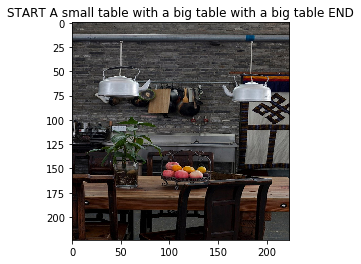

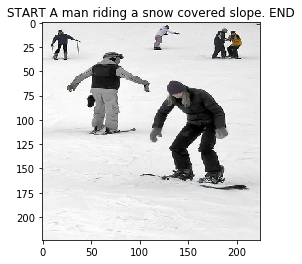

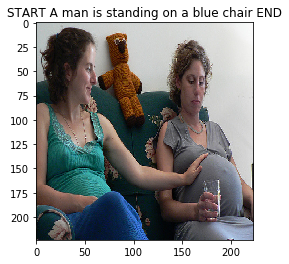

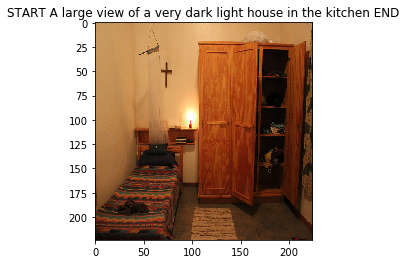

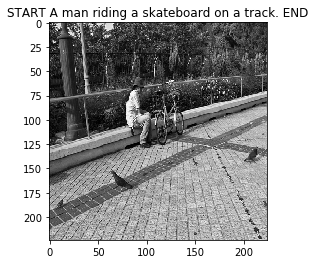

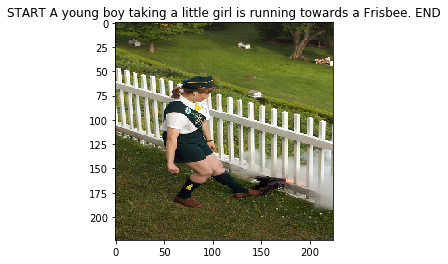

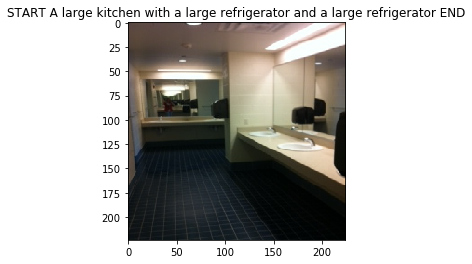

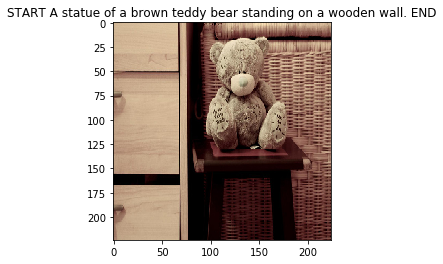

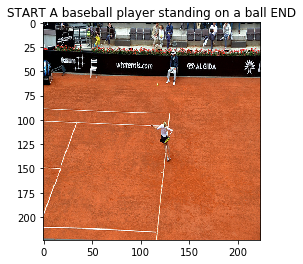

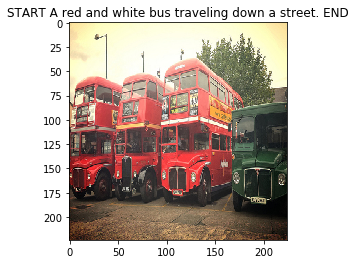

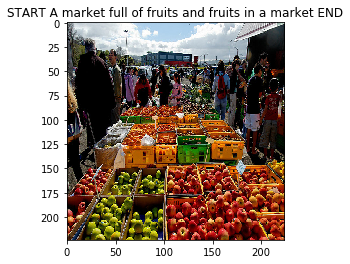

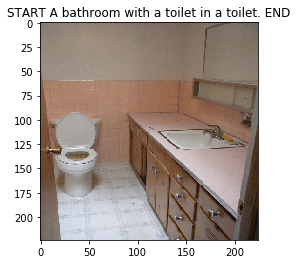

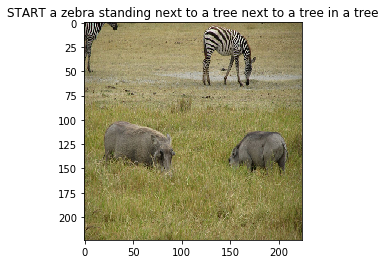

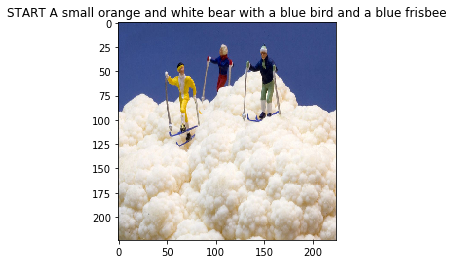

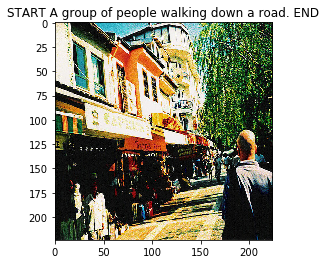

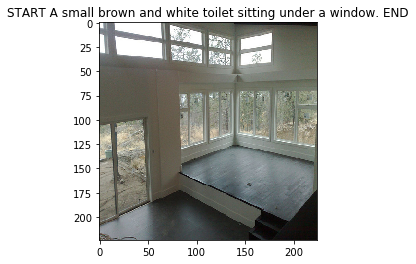

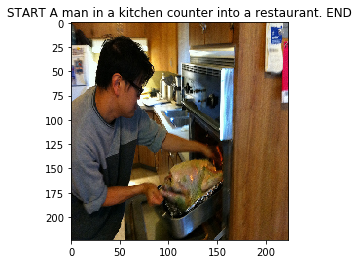

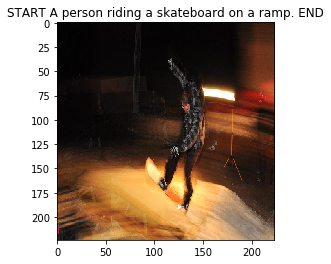

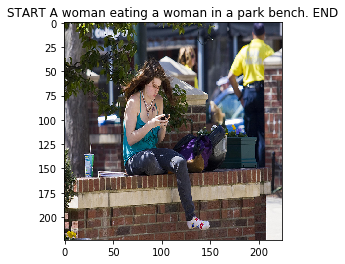

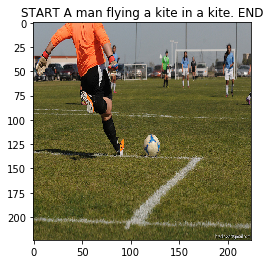

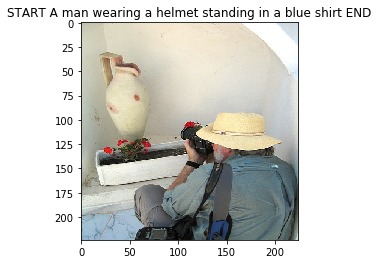

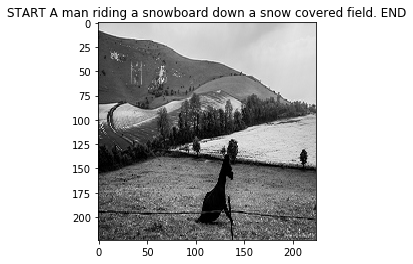

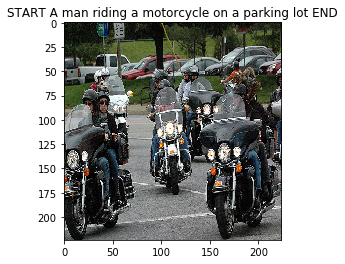

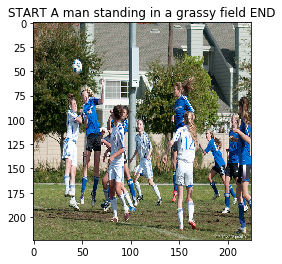

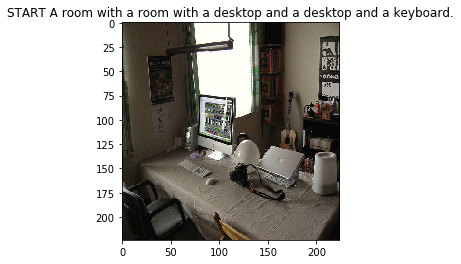

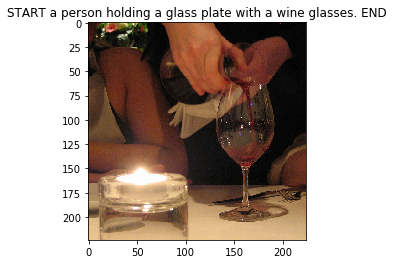

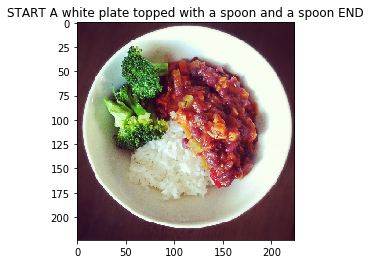

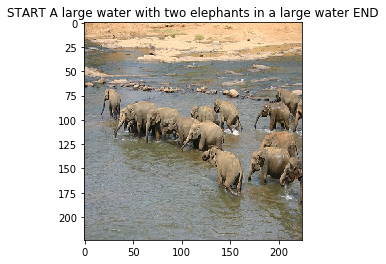

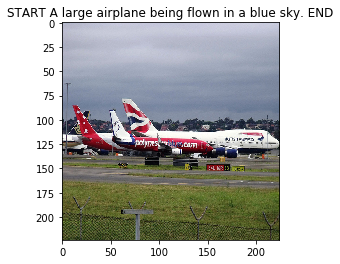

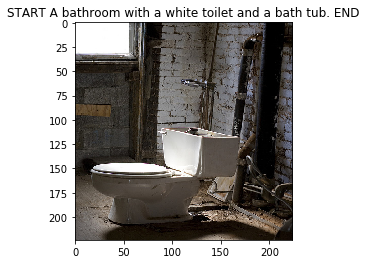

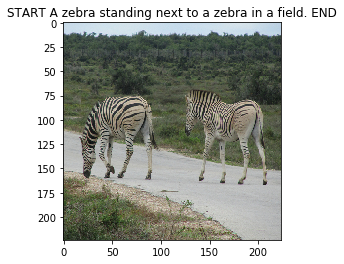

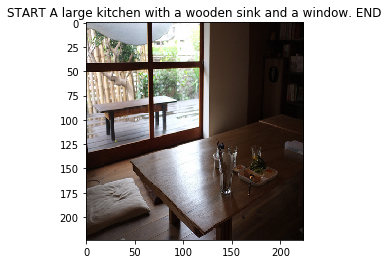

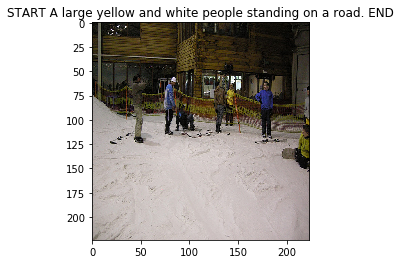

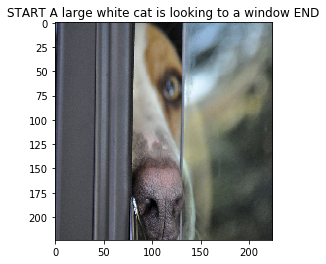

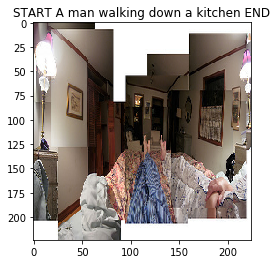

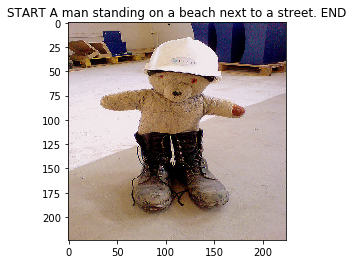

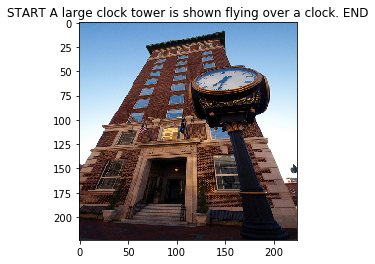

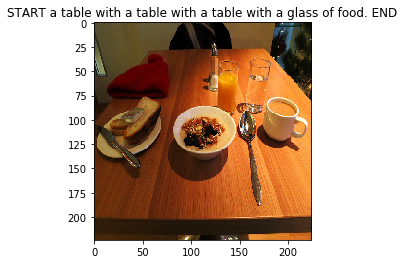

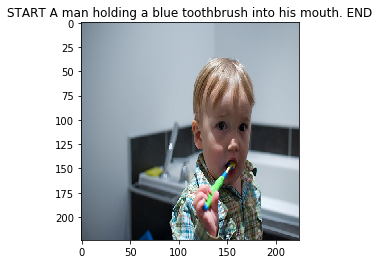

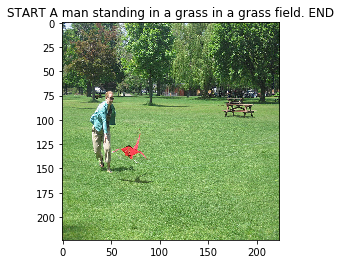

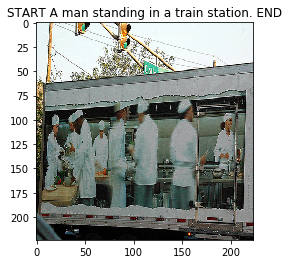

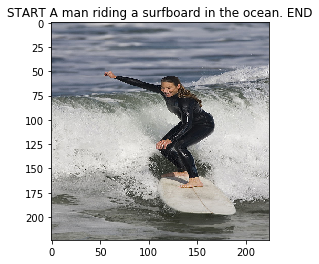

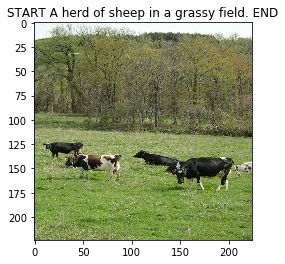

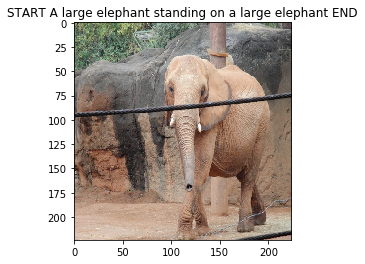

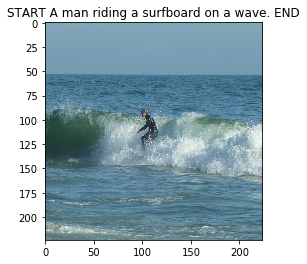

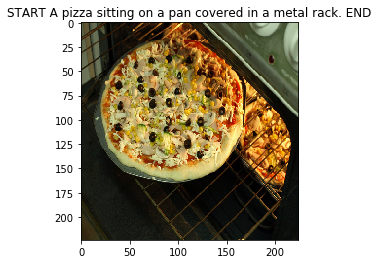

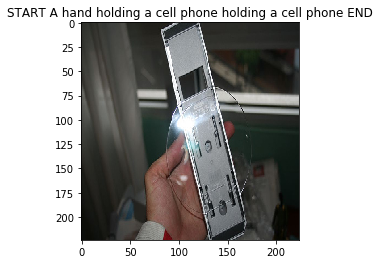

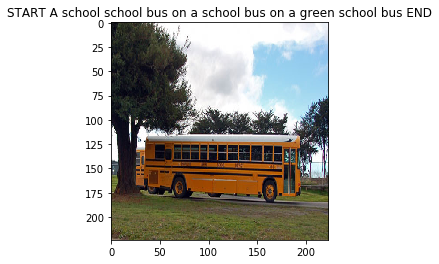

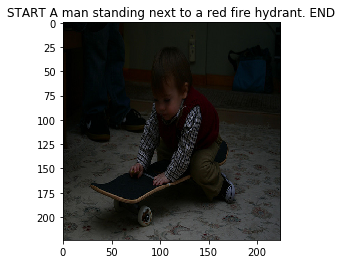

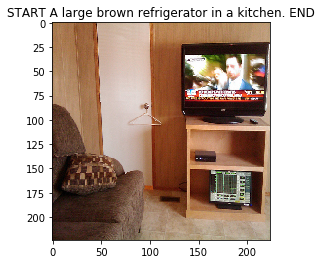

In [46]:
plot_predictions(images,titles = predicted_captions)

In [ ]:
def bleu_score_metric(reality, prediction):
    return nltk.translate.bleu_score.sentence_bleu([reality], prediction)

In [ ]:
def compute_bleu_score_metric(predicted_captions, real_captions):
    bleu_scores = [bleu_score_metric(real_captions[i], predicted_captions[i]) for i in range(len(predicted_captions))]
    return np.average(bleu_scores)


In [ ]:
compute_bleu_score_metric(predicted_captions, real_captions)

In [ ]:
def most_common_words(captions,word_limit):
    
    sentences = [caption.split() for caption in captions]
    words = []
    for word in sentences:
        words.extend(word)

    counter=collections.Counter(words)
    return counter.most_common(word_limit)


In [ ]:
common_words2app = most_common_words(predicted_captions,50)
common_words2app = [(word,app) for word,app in common_words2app if word.lower() not in stopwords.words('english')]
common_words2app = [(word,app) for word,app in common_words2app if word not in ['START','END']]


In [ ]:
common_words2app

In [ ]:
searched_word = "baseball"
(found_images,found_captions) = search_images_by(searched_word,images,predicted_captions)
print("Number of results = %d"%len(found_images))

In [ ]:
plot_predictions(found_images,found_captions)